In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0437cf51
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0437cf51
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=38f276388da10501466c3e1a57df276a9f06f58b37aeebb8f6947eb26f0f6ab6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ngrkz6c/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
import tensorflow as tf

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Loading the dataset

In [5]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create Models

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

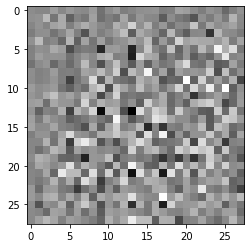

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00025577]], shape=(1, 1), dtype=float32)


# Define Loss and Optimizers

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
#The discriminator and the generator optimizers are different since you will train two networks separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# TRAIN THE MODEL

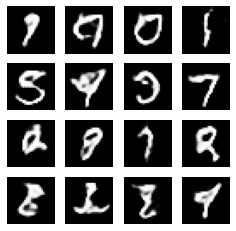

In [22]:
train(train_dataset, EPOCHS)

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

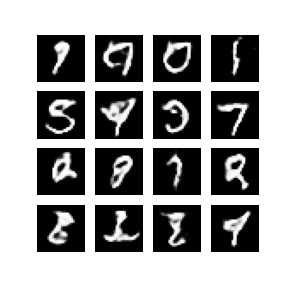

In [25]:
display_image(EPOCHS)

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


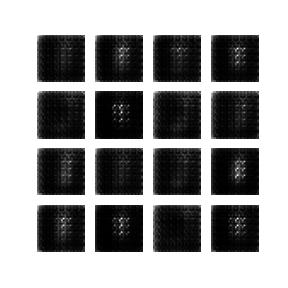

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# For Electron-Photon dataset

In [ ]:
!pip install tensorflow-quantum

In [29]:
import tensorflow as tf
import tensorflow_quantum as tfq

In [30]:
import os
import glob
import operator
import numpy as np
import pandas

In [31]:
if 'google.colab' in str(get_ipython()):
  !wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/electron-photon.npz

--2022-06-29 10:44:13--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/electron-photon.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.184.104.112, 188.184.31.136, 188.185.68.13, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.184.104.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 821002 (802K) [application/zip]
Saving to: ‘electron-photon.npz’

electron-photon.npz 100%[===================>] 801.76K  1.20MB/s    in 0.7s    

2022-06-29 10:44:15 (1.20 MB/s) - ‘electron-photon.npz’ saved [821002/821002]



In [32]:
data = dict(np.load('electron-photon.npz'))
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
print('Min(Max) of training sample: {}({:.4f})'.format(np.min(x_train), np.max(x_train)))
print('Min(Max) of test sample: {}({:.4f})'.format(np.min(x_test), np.max(x_test)))
print('Dimension of training sample: {}'.format(x_train.shape))
print('Dimension of test sample: {}'.format(x_test.shape))

Min(Max) of training sample: 0.0(1.4274)
Min(Max) of test sample: 0.0(1.3920)
Dimension of training sample: (100, 32, 32)
Dimension of test sample: (100, 32, 32)


In [33]:
data['y_train']

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

In [207]:
photon = []
plabel = []
for i in range(data['y_train'].shape[0]):
  if data['y_train'][i] == 1:
    photon.append(data['x_train'][i])
    plabel.append(data['y_train'][i])

px = np.asarray(photon)
print('photon train data shape:',px.shape)
py = np.asarray(plabel)
print('photon train label shape:',py.shape)

photon train data shape: (56, 32, 32)
photon train label shape: (56,)


In [208]:
photont = []
plabelt = []
for i in range(data['y_test'].shape[0]):
  if data['y_test'][i] == 1:
    photont.append(data['x_test'][i])
    plabelt.append(data['y_test'][i])

pxt = np.asarray(photont)
print('photon_test shape:',pxt.shape)
pyt = np.asarray(plabelt)
print('photon_test label shape:',pyt.shape)

photon_test shape: (46, 32, 32)
photon_test label shape: (46,)


In [209]:
import matplotlib.pyplot as plt
particle_label_map = {
    0: 'photon',
    1: 'electron'
}

In [210]:
# Visualize the data
from typing import Optional,Dict
def visualize_images(images:"numpy.ndarray", columns:int=8, subplots_options:Optional[Dict]=None,
                     labels:Optional["numpy.ndarray"]=None, label_map:Optional[Dict]=None):
    plt.clf()
    size = images.shape[0]
    rows = ( size // columns ) + 1
    fig = plt.figure(figsize=(20, rows*3))
    if (labels is not None) and (label_map is not None):
        assert labels.shape[0] == images.shape[0]
        titles = ["Image {}: {}".format(i, label_map[labels[i]]) for i in range(size)]
    else:
        titles = [None]*size
    for i in range(images.shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title(titles[i])
        ax.imshow(images[i])
    if subplots_options is not None:
        plt.subplots_adjust(**subplots_options)
    return plt


In [211]:
#Crop image 
def crop_image(img, dimension):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, dimension))
    end = tuple(map(operator.add, start, dimension))
    slices = tuple(map(slice, start, end))
    return img[slices]

crop_size = (8, 8)
x_train_cropped = np.array([crop_image(i, crop_size) for i in px])
x_test_cropped = np.array([crop_image(i, crop_size) for i in pxt])

In [212]:
def visualize_image(img, labels):
    fig = plt.figure(figsize=(20,40))
    columns = 7
    rows = 15
    plt.subplots_adjust(hspace=0.3)
    for i in range(img.shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Image {}: {}'.format(i+1, particle_label_map[labels[i]]))
        plt.imshow(img[i])
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

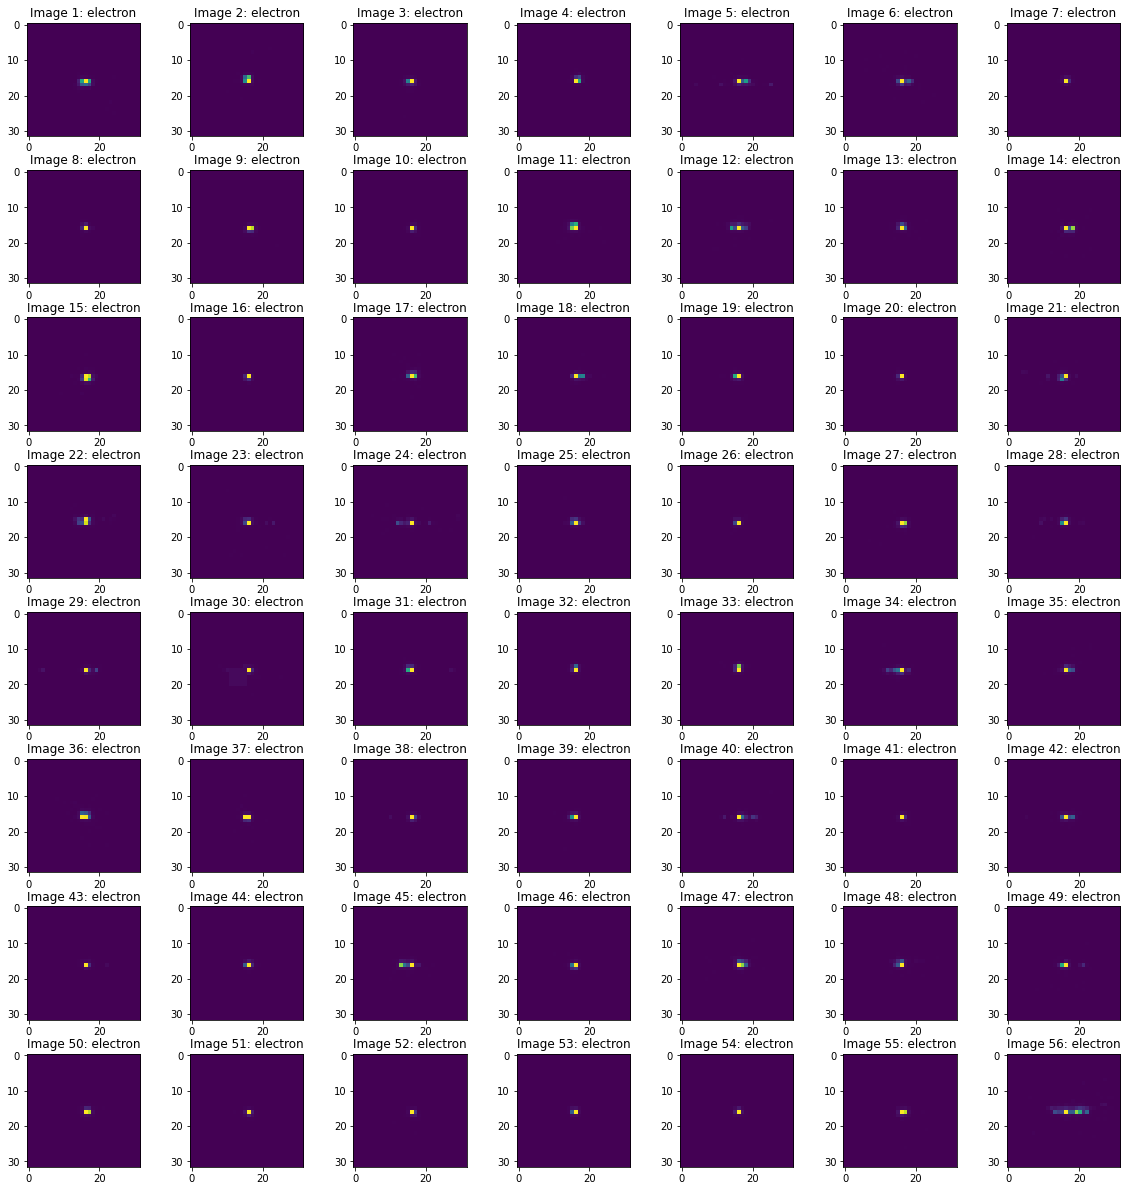

In [213]:
visualize_image(px,py)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

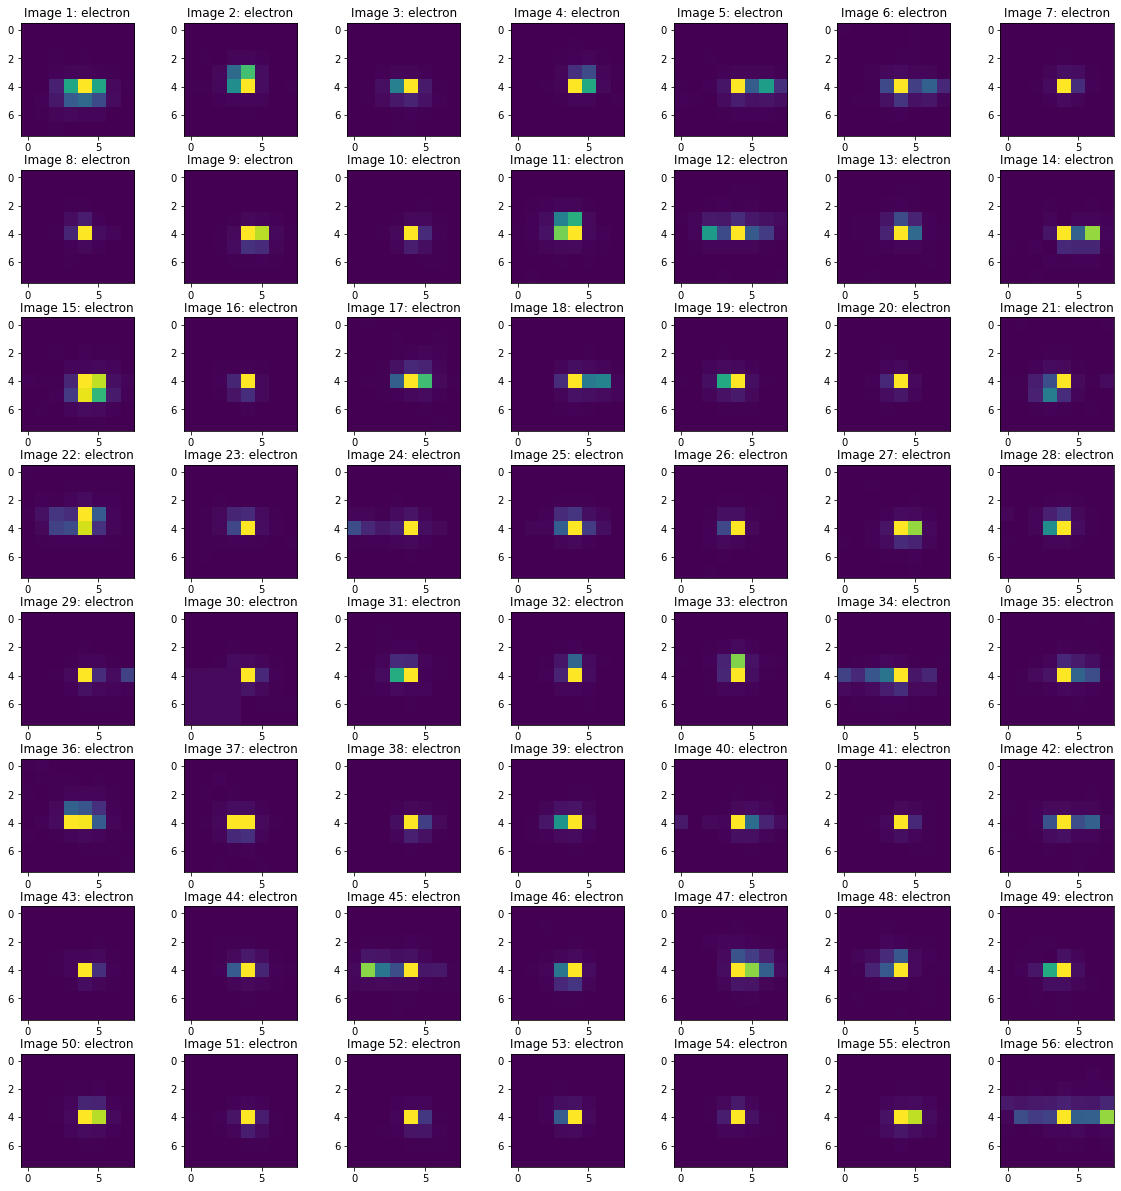

In [173]:
#Cropped image visualisation
visualize_image(x_train_cropped,py)

In [174]:
def rescale_data(*data, val_range:tuple=(0, 1.)):
    min_value = np.min([np.min(d) for d in data])
    max_value = np.max([np.max(d) for d in data])
    range_min = val_range[0]
    range_max = val_range[1]
    rescaled_data = tuple([(((d-min_value)/(max_value-min_value))*(range_max-range_min))+range_min for d in data])
    if len(rescaled_data) == 1:
        return rescaled_data[0]
    return rescaled_data

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

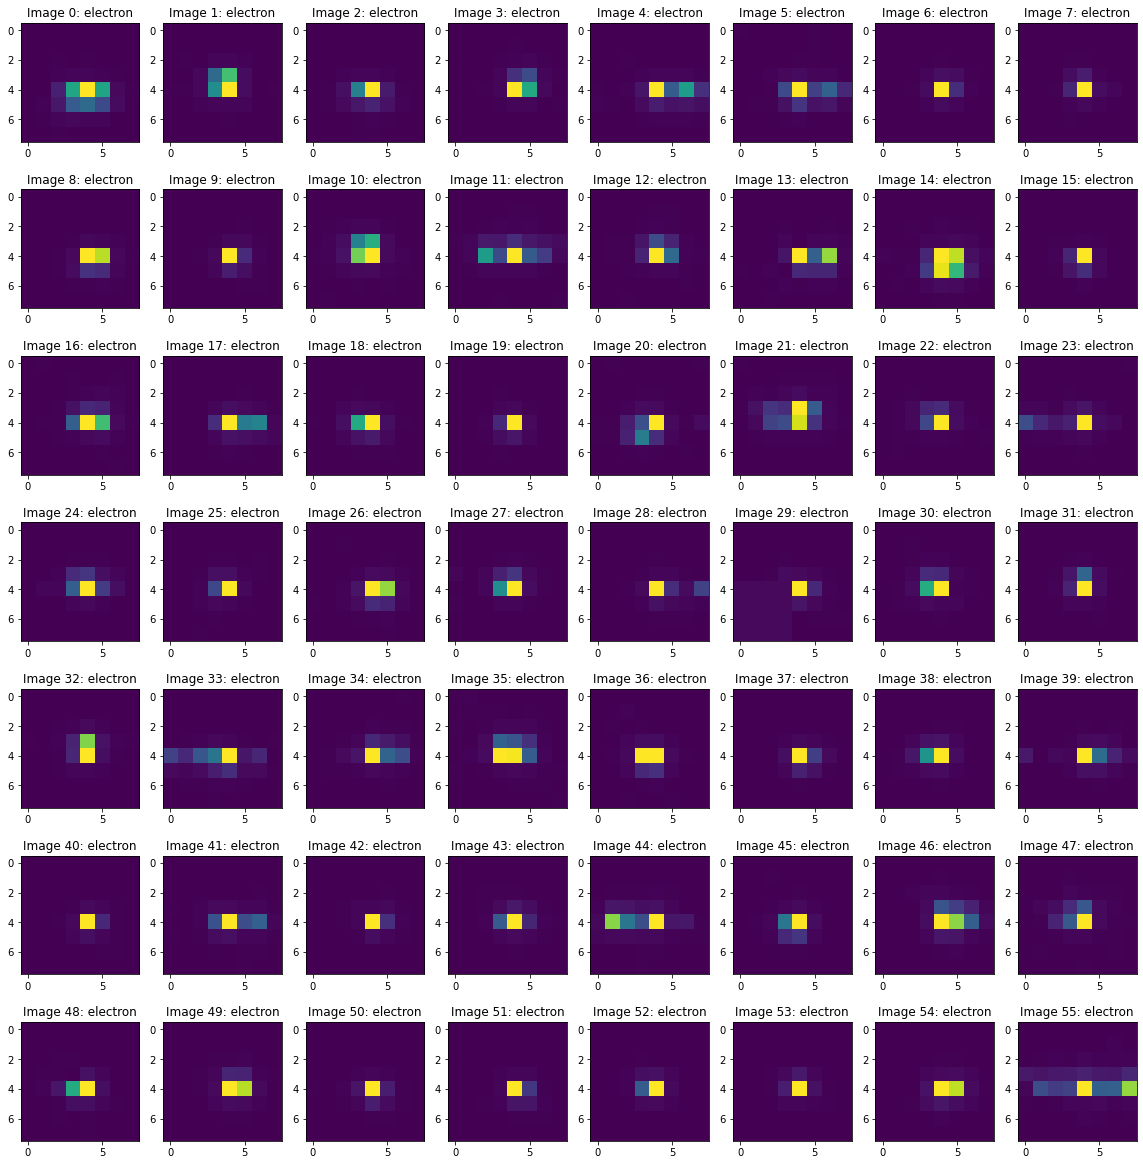

In [175]:
x_train_rescaled, x_test_rescaled = rescale_data(x_train_cropped, x_test_cropped, val_range=(-1, 1))
visualize_images(x_train_rescaled[:], labels=py[:], label_map=particle_label_map)

In [176]:
x_train_final = np.reshape(x_train_rescaled, (x_train_rescaled.shape[0], 8, 8))
x_test_final = np.reshape(x_test_rescaled, (x_test_rescaled.shape[0], 8, 8))

In [177]:
#Normalise data
from sklearn import preprocessing
for i in range(x_train_final.shape[0]):
  x_train_final[i] = preprocessing.normalize(x_train_final[i])

for j in range(x_test_final.shape[0]):
  x_test_final[j] = preprocessing.normalize(x_test_final[j])

## Creating the GAN model

In [45]:
# from tensorflow.keras import layers
# def make_generator_model():
#     model = tf.keras.Sequential()
#     # foundation for 2x2 image
#     n_nodes = 64 * 2 * 2
#     model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Reshape((2, 2, 64)))

#     model.add(tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(1,1), padding="same", use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     # upsample to 4x4
#     model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same", use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())    
#     # upsample to 8x8
#     model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False, activation='tanh'))
#     return model

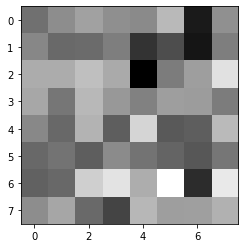

In [46]:
# generator = make_generator_model()

# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [47]:
# def create_classical_discriminator():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[8, 8, 1]))
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Dropout(0.3))

#     model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Dropout(0.3))

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(1))
#     return model

In [48]:
# discriminator = create_classical_discriminator()
# decision = discriminator(generated_image)
# print (decision)

tf.Tensor([[-0.02085388]], shape=(1, 1), dtype=float32)


# Loss function definition

In [178]:
#dEFINE LOSS AND OPTIMIZERS
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [179]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [180]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [181]:
generator_optimizer_ep = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer_ep = tf.keras.optimizers.Adam(5e-4)

In [182]:
EPOCHS = 50
noise_dim = 2021
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [183]:
def generate_and_save_images_ep(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [184]:
BUFFER_SIZE = x_train_final.shape[0]

In [185]:
BATCH_SIZE = 16
train_dataset_ep = tf.data.Dataset.from_tensor_slices(x_train_final).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GENERATOR - EPD

In [186]:
def make_generator_model_ep():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2 * 2 * 64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, 64)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 8, 8, 1)

    return model

In [187]:
def create_classical_discriminator_ep():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[8, 8, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               25600     
                                                                 
 batch_normalization_30 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 256)               0         
                                                                 
 reshape_10 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 2, 2, 32)         51200     
 Transpose)                                                      
                                                                 
 batch_normalization_31 (Bat  (None, 2, 2, 32)       

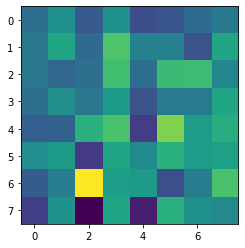

In [188]:
generator_ep = make_generator_model_ep()
print(generator_ep.summary())

noise = tf.random.normal([1, 100])
generated_image_ep = generator_ep(noise, training=False)

plt.imshow(generated_image_ep[0, :, :, 0])

In [189]:
discriminator_ep = create_classical_discriminator_ep()
print(discriminator_ep.summary())
decision_ep = discriminator_ep(generated_image_ep)
print (decision_ep)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 4, 4, 64)          640       
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 dropout_18 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 128)         32896     
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 2, 2, 128)         0         
                                                                 
 dropout_19 (Dropout)        (None, 2, 2, 128)         0         
                                                                 
 flatten_9 (Flatten)         (None, 512)             

In [190]:
checkpoint_dir_ep = './training_checkpoints/GAN/photon_image_8x8'
checkpoint_prefix_ep = os.path.join(checkpoint_dir, "ckpt")
checkpoint_ep = tf.train.Checkpoint(generator_optimizer=generator_optimizer_ep,
                                 discriminator_optimizer=discriminator_optimizer_ep,
                                 generator=generator_ep,
                                 discriminator=discriminator_ep)

In [191]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [192]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_ep(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images_ep = generator_ep(noise, training=True)

      real_output_ep = discriminator_ep(images, training=True)
      fake_output_ep = discriminator_ep(generated_images_ep, training=True)

      gen_loss_ep = generator_loss(fake_output_ep)
      disc_loss_ep = discriminator_loss(real_output_ep, fake_output_ep)

    gradients_of_generator_ep = gen_tape.gradient(gen_loss_ep, generator_ep.trainable_variables)
    gradients_of_discriminator_ep = disc_tape.gradient(disc_loss_ep, discriminator_ep.trainable_variables)

    generator_optimizer_ep.apply_gradients(zip(gradients_of_generator_ep, generator_ep.trainable_variables))
    discriminator_optimizer_ep.apply_gradients(zip(gradients_of_discriminator_ep, discriminator_ep.trainable_variables))

In [194]:
def train_ep(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step_ep(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images_ep(generator_ep,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint_ep.save(file_prefix = checkpoint_prefix_ep)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images_ep(generator_ep,
                           epochs,
                           seed)

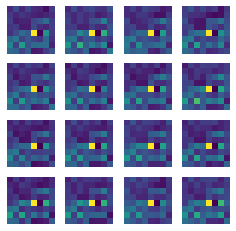

In [195]:
train_ep(train_dataset_ep,70)

In [196]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_ep))

In [198]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

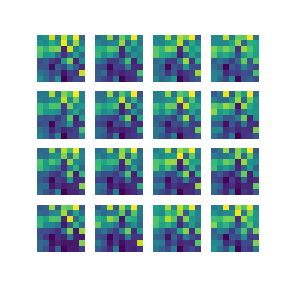

In [199]:
display_image(EPOCHS)

In [200]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


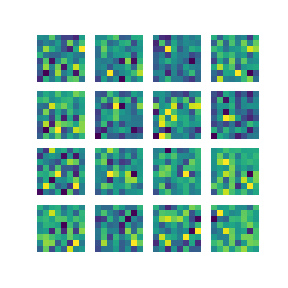

In [201]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [197]:
# optimizer_kwargs = {
#     "generator": {"learning_rate": 5e-4},
#     "discriminator": {"learning_rate": 5e-4}
# }

# classical_gan = QGAN(generator, discriminator,
#             epochs=70, batch_size=16,
#             n_disc=1,
#             optimizer="adam",
#             optimizer_kwargs=optimizer_kwargs,
#             random_state=2021, 
#             checkpoint_dir="./training_checkpoints/GAN/photon_image_8x8")
# classical_gan.enable_visualization((8, 8), n_image=16)